## Understanding recurrent neural networks (RNN)

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that **they have no memory**. Each input shown to them is processed independently, with no state kept in between inputs. With such networks, **in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once**: turn it into a single data point. 

### Understanding the LSTM and GRU layers

SimpleRNN isn’t the only recurrent layer available in Keras. There are two others: 
* LSTM and 
* GRU 

In practice, you’ll always use one of these, because SimpleRNN is generally too simplistic to be of real use. **SimpleRNN has a major issue:** although it should theoretically be able to retain at time t information about inputs seen many timesteps before, **in practice, such long-term dependencies are impossible to learn**. This is **due to the vanishing gradient problem**, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) **that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable**. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s. 

**The LSTM and GRU layers are designed to solve this problem.**

Let’s consider the LSTM layer. The **underlying Long Short-Term Memory ( LSTM ) algorithm** was developed by Hochreiter and Schmidhuber in 1997; it was the culmination of their research on the **vanishing gradient problem**.

This layer is a variant of the SimpleRNN layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: **it saves information for later, thus preventing older signals from gradually vanishing during processing**.

Just keep in mind what the LSTM cell is meant to do: **allow past information to be reinjected at a later time**, thus fighting the vanishing-gradient problem.

### A temperature-forecasting problem

You have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which you use to **predict what the temperature will be 24 hours after the last data point**. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We’ll cover the following techniques:

* **Recurrent dropout** This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* **Stacking recurrent layers** This increases the representational power of the network (at the cost of higher computational loads).
* **Bidirectional recurrent layers** These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

#### DESCRIPTION:
In this dataset we have 14 different quantities: 

* air temperature, 
* atmospheric pressure, 
* humidity, 
* wind direction
* ...

These were **recorded every 10 minutes**, over several years. 

The original data goes back to 2003, but **this example is limited to data from 2009–2016**. This dataset is perfect for learning to work with numerical timeseries. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and **predicts the air temperature 24 hours in the future**

In [227]:
import os
data_dir = '/home/erikapat/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [228]:
type(data)

str

In [229]:
lines[0:3]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60']

In [230]:
# eliminate the first column and organize everthing in a numpy array
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [231]:
float_data.shape


(420551, 14)

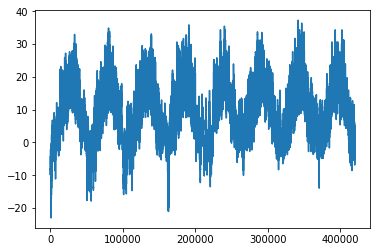

In [232]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)


## 10-day period must be coming

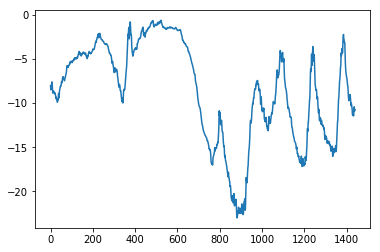

In [233]:
plt.plot(range(1440), temp[:1440])

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that **this 10-day period must be coming from a fairly cold winter month**.

If you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data.

The exact formulation of the problem will be as follows: 

**given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps?**

You’ll use the following parameter values:

* lookback = 720 —Observations will go back 5 days.
* steps = 6 —Observations will be sampled at one data point per hour.
* delay = 144 —Targets will be 24 hours in the future.

To get started, you need to do two things:

1. Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.

2. Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data.

3. You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. **You’re going to use the first 400,000 timesteps as training data**, so compute the mean and standard deviation only on this fraction of the data.

**Let's normalize the data.**

In [238]:
mean = float_data[:400000].mean(axis=0)
float_data -= mean
std = float_data[:400000].std(axis=0)
float_data /= std

In [239]:
float_data.shape

(420551, 14)

In [240]:
float_data

array([[ 0.90971069, -2.06986869, -2.12759064, ..., -0.00997989,
        -0.01852541, -0.25988789],
       [ 0.91572957, -2.11611922, -2.17344243, ..., -0.01459943,
        -0.02205817, -0.44643954],
       [ 0.91091447, -2.12797833, -2.1851993 , ..., -0.02249736,
        -0.03435219, -0.03763809],
       ...,
       [ 1.30695646, -1.49351588, -1.58559896, ..., -0.0092348 ,
        -0.01499265,  0.46443919],
       [ 1.30575269, -1.62040837, -1.71139747, ..., -0.00312508,
        -0.01273168,  0.58650385],
       [ 1.30695646, -1.69037713, -1.77958731, ..., -0.00699954,
        -0.01555789,  0.11551851]])

**Let's create a data generator which returns (samples, targets), where samples is the number of samples equal to batch size and targets is an array of target temperatures.**

* **data**: The original array of floating-point data, which you normalized.
* **lookback**: How many timesteps back the input data should go.
* **delay**: How many timesteps in the future the target should be.
* **min_index and max_index**: Indices in the data array that delimit which time-steps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
* **shuffle:** Whether to shuffle the samples or draw them in chronological order.
* **batch_size:** The number of samples per batch.
* **step:** The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour.

In [241]:

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

**Let's create three generators for training (400.000 samples), validation (next 20.000) and testing (remaining).**

In [252]:
# past 10  days = 10days*(24*6day)
lookback = 1440 # líneas, representa 10 días
step = 6 # this is the number of lines that represents an hour
#24 hours in the future
delay = 144
# sample of data...
batch_size = 128

lookback // step # timesteps (NÚMERO DE HORAS) 10 DÍAS SON 240 HORAS...

240

In [242]:
##Preparing the training, validation, and test generators

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=400000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=400001,
                    max_index=420000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                            lookback=lookback,
                            delay=delay,
                            min_index=420001,
                            max_index=None,
                            step=step,
                            batch_size=batch_size)
#How many steps to draw from val_gen in order to see the
#entire validation set
val_steps = (420000 - 400001 - lookback)
test_steps = (len(float_data) - 400001 - lookback)

In [243]:
train_gen

<generator object generator at 0x7fe07056d518>

In [244]:
val_steps

18559

In [245]:
test_steps

19110

## A common-sense, non-machine-learning baseline

Before you start using **black-box deep-learning models**to solve the temperature- prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models. **Such common-sense base- lines can be useful when you’re approaching a new problem for which there is no known solution (yet)**. 

**A classic example is that of unbalanced classification tasks, where some classes are much more common than others**. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. **Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness**. Sometimes, such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous **-- the temperatures tomorrow are likely to be close to the temperatures today--** as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now.

In [217]:
##Computing the common-sense baseline MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        print(str(step) + ' of ' + str(val_steps))
    print(np.mean(batch_maes))

In [ ]:
samples, targets = next(val_gen)

### 3D tensors (samples, timesteps, features)

* timesteps: quieres 24 horas en adelante, los datos son de cada 10 min, esto es 6 steps de 10 min es una hora, 24

In [247]:
6*24

144

In [219]:
print(samples.shape)
print(targets.shape)

(128, 240, 14)
(128,)


In [199]:
targets

array([-0.50238344, -0.51480931, -0.51932781, -0.50916119, -0.51706856,
       -0.5374018 , -0.5374018 , -0.5374018 , -0.54304992, -0.53627218,
       -0.53514255, -0.53062405, -0.53627218, -0.53627218, -0.53401293,
       -0.53966105, -0.54304992, -0.54756842, -0.54756842, -0.5328833 ,
       -0.53627218, -0.53514255, -0.5419203 , -0.52949443, -0.52271668,
       -0.51142044, -0.54530917, -0.56564241, -0.55773504, -0.55999429,
       -0.57016091, -0.56790166, -0.55660542, -0.57242016, -0.57129054,
       -0.57693866, -0.5419203 , -0.53627218, -0.5419203 , -0.52045743,
       -0.51706856, -0.49221682, -0.51142044, -0.53401293, -0.52723518,
       -0.51255006, -0.49221682, -0.4730132 , -0.45380959, -0.45719846,
       -0.44816146, -0.43234672, -0.40636536, -0.40184686, -0.39393949,
       -0.40636536, -0.4131431 , -0.42330972, -0.42443935, -0.42895785,
       -0.43573559, -0.43347635, -0.43460597, -0.44251334, -0.44025409,
       -0.44364297, -0.43686522, -0.43686522, -0.4312171 , -0.42

In [191]:
evaluate_naive_method()

0 of 18559
1 of 18559
2 of 18559
3 of 18559
4 of 18559
5 of 18559
6 of 18559
7 of 18559
8 of 18559
9 of 18559
10 of 18559
11 of 18559
12 of 18559
13 of 18559
14 of 18559
15 of 18559
16 of 18559
17 of 18559
18 of 18559
19 of 18559
20 of 18559
21 of 18559
22 of 18559
23 of 18559
24 of 18559
25 of 18559
26 of 18559
27 of 18559
28 of 18559
29 of 18559
30 of 18559
31 of 18559
32 of 18559
33 of 18559
34 of 18559
35 of 18559
36 of 18559
37 of 18559
38 of 18559
39 of 18559
40 of 18559
41 of 18559
42 of 18559
43 of 18559
44 of 18559
45 of 18559
46 of 18559
47 of 18559
48 of 18559
49 of 18559
50 of 18559
51 of 18559
52 of 18559
53 of 18559
54 of 18559
55 of 18559
56 of 18559
57 of 18559
58 of 18559
59 of 18559
60 of 18559
61 of 18559
62 of 18559
63 of 18559
64 of 18559
65 of 18559
66 of 18559
67 of 18559
68 of 18559
69 of 18559
70 of 18559
71 of 18559
72 of 18559
73 of 18559
74 of 18559
75 of 18559
76 of 18559
77 of 18559
78 of 18559
79 of 18559
80 of 18559
81 of 18559
82 of 18559
83 of 18559
84

In [14]:
##Training and evaluating a densely connected model
from keras.models import Sequential
from keras.optimizers import RMSprop

from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics


Using TensorFlow backend.


In [254]:
lookback // step

240

In [253]:
float_data.shape[-1]

14

In [15]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))


In [16]:
#model.compile(optimizer=RMSprop(), loss='mae')
model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.MAE)

In [17]:
help(model.fit_generator)

Help on method fit_generator in module keras.engine.training:

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0) method of keras.engine.sequential.Sequential instance
    Trains the model on data generated batch-by-batch by a Python generator (or an instance of `Sequence`).
    
    The generator is run in parallel to the model, for efficiency.
    For instance, this allows you to do real-time data augmentation
    on images on CPU in parallel to training your model on GPU.
    
    The use of `keras.utils.Sequence` guarantees the ordering
    and guarantees the single use of every input per epoch when
    using `use_multiprocessing=True`.
    
    # Arguments
        generator: A generator or an instance of `Sequence`
            (`keras.utils.Sequence`) object in order to avoid
            duplicate d

In [19]:
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                verbose = 1, 
                                #use_multiprocessing=True
                                validation_data=val_gen,
                                validation_steps= 1000) #val_steps)

Epoch 1/20
500/500 [==============================] - 21s 42ms/step - loss: 1.4904 - val_loss: 0.4995
Epoch 2/20
500/500 [==============================] - 21s 42ms/step - loss: 0.5158 - val_loss: 0.3415
Epoch 3/20
500/500 [==============================] - 20s 41ms/step - loss: 0.3033 - val_loss: 0.3140
Epoch 4/20
500/500 [==============================] - 20s 41ms/step - loss: 0.2703 - val_loss: 0.3135
Epoch 5/20
500/500 [==============================] - 26s 52ms/step - loss: 0.2570 - val_loss: 0.3067
Epoch 6/20
500/500 [==============================] - 25s 50ms/step - loss: 0.2453 - val_loss: 0.3286
Epoch 7/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2366 - val_loss: 0.3247
Epoch 8/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2312 - val_loss: 0.3285
Epoch 9/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2264 - val_loss: 0.3296
Epoch 10/20
500/500 [==============================] - 22s 43ms/step - loss: 0.220

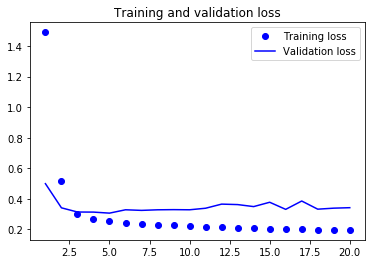

In [20]:
##Plotting results
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
help(model.fit_generator)

## A first recurrent baseline

In [23]:
## Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=20,
                                validation_data=val_gen,
                                validation_steps=val_steps)

Epoch 1/20
  9/500 [..............................] - ETA: 5:28 - loss: 0.4300

KeyboardInterrupt: 